# Benchmarking spatial mapping of cell types in the mouse brain

## Loading packages

In [1]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os
import pandas as pd
from matplotlib import rcParams
import seaborn as sns

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location

import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
cell2location

<module 'cell2location' from '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/cell2location/__init__.py'>

## 1. Loading cell2location results <a name="loading"></a>

In [3]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_data/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/mouse_zeisel/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/zeisel/'
vis_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/'

run = {'run_name': 'LocationModelLinearDependentWMultiExperiment_5experiments_175clusters_14968locations_12570genes_matching_regions_30k'}
run = {'run_name': 'LocationModelLinearDependentWMultiExperimentFixedGeneMeanAlpha_5experiments_175clusters_14968locations_12570genes_matching_regions_30k_mg_alpha100'}


# path for saving figures
fig_path = f'{results_folder}{run["run_name"]}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

sp_data_file = results_folder +run['run_name']+'/sp.h5ad'
adata_vis = anndata.read(sp_data_file)

adata_vis.obs[adata_vis.uns['mod']['fact_names']] = adata_vis.uns['mod']['post_sample_q05']['spot_factors']
adata_vis.shape

(14968, 31053)

In [4]:
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [5]:
## snRNAseq reference (raw counts)
regression_model_output = 'RegressionGeneBackgroundCoverageTorch_263covariates_94986cells_12620genes'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
adata_snrna_raw.shape

(94986, 12620)

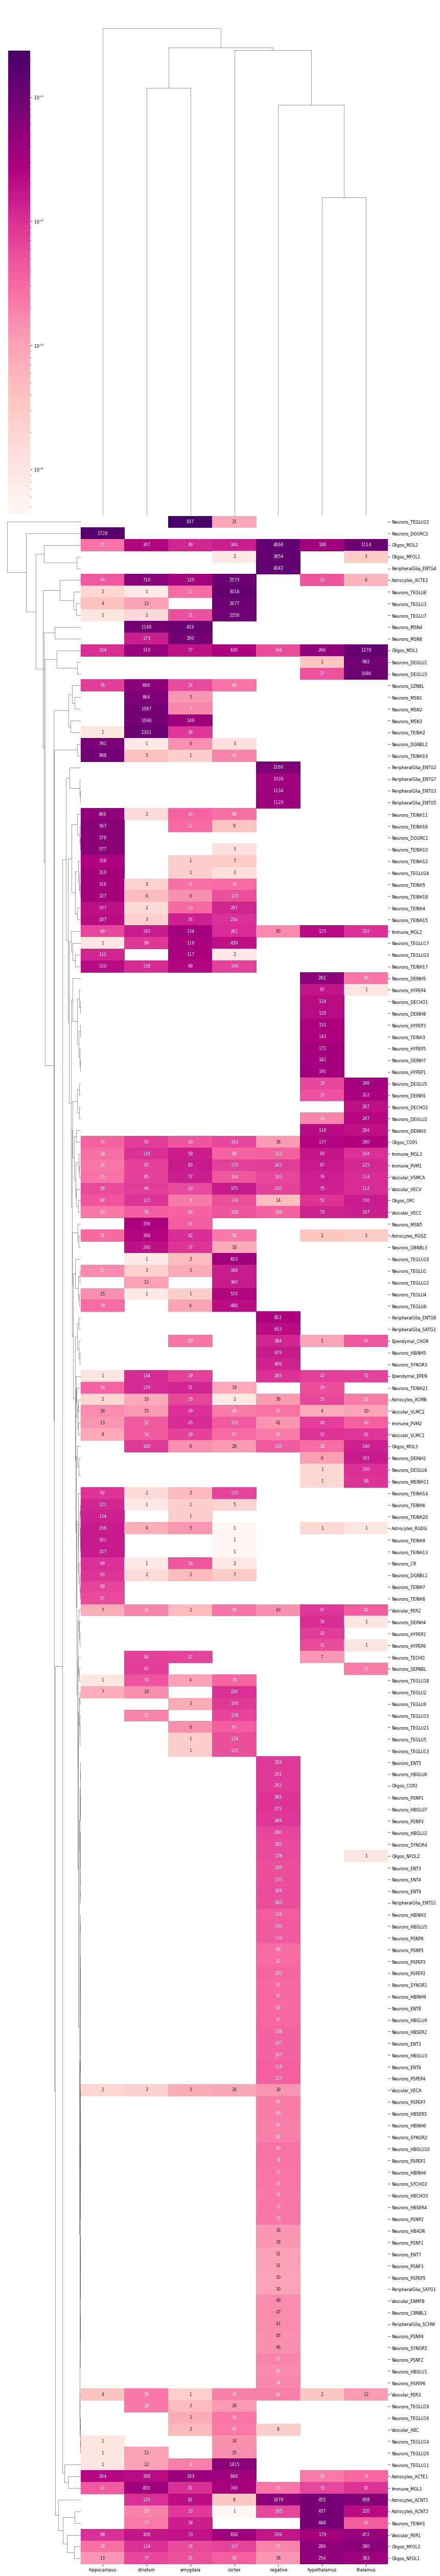

In [6]:
# check which clusters are in which section
def count_cells(adata, sample, cluster):
    
    return (adata.obs['matching_region'].isin([sample]) & adata.obs['Class_ClusterName'].isin([cluster])).sum()
    
count_mat = [[count_cells(adata_snrna_raw, i, j) 
              for i in adata_snrna_raw.obs['matching_region'].unique()]
             for j in adata_snrna_raw.obs['Class_ClusterName'].unique()]
count_df = pd.DataFrame(count_mat, index=adata_snrna_raw.obs['Class_ClusterName'].unique(), 
                        columns=adata_snrna_raw.obs['matching_region'].unique())
#count_fraq_df = (count_df.T / count_df.sum(1)).T
count_fraq_df = count_df / count_df.sum(0)
count_df = count_df.astype(int)

#mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

with mpl.rc_context({'axes.facecolor': 'white', 'font.size': 8}):
    fig = sns.clustermap(count_fraq_df, figsize=[12, 70], cmap='RdPu', 
                   norm=mpl.colors.LogNorm(),
                   row_cluster=True, annot_kws={'rotation': 0},
                   annot=count_df.astype(int), fmt='d')
    plt.savefig(f"{fig_path}cell_types_per_matching_region.pdf", bbox_inches='tight')

## 2. Extract gold standard annotations <a name="loading2"></a>

In [7]:
# read region annotations
# annotate region clusters
run_name = 'LocationModelLinearDependentWMultiExperiment_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k'
region_annot = pd.read_csv(f'{vis_results_folder}{run_name}/20200904_regionAnnotation_per_location.csv',
                           index_col='spot_id')
adata_vis.obs[region_annot.columns] = region_annot.loc[adata_vis.obs_names,:]

# keep only the locations that match reference
adata_vis_matching = adata_vis[adata_vis.obs['location'].isin(count_df.columns),:]
adata_vis_matching.obs['location'].value_counts()

cortex          4951
thalamus        2623
hypothalamus    1866
hippocampus     1064
amygdala         820
striatum         561
Name: location, dtype: int64

In [8]:
gold_standard = count_df.copy() > 10
gold_standard.index = [f'gold_standard_{i}' for i in gold_standard.index]

# remove negative category
gold_standard = gold_standard[gold_standard.columns[gold_standard.columns != 'negative']]
gold_standard = gold_standard.loc[gold_standard.sum(1) > 0,:]

for ct in gold_standard.index:
    gold_regions = gold_standard.loc[ct] > 0
    gold_regions = gold_regions.index[gold_regions]
    adata_vis_matching.obs[ct] = adata_vis_matching.obs['location'].isin(gold_regions).astype(float)
    
adata_vis_matching.obs[gold_standard.index]

Trying to set attribute `.obs` of view, copying.


,gold_standard_Astrocytes_ACMB,gold_standard_Astrocytes_ACNT1,gold_standard_Astrocytes_ACNT2,gold_standard_Astrocytes_ACTE1,gold_standard_Astrocytes_ACTE2,gold_standard_Astrocytes_RGDG,gold_standard_Astrocytes_RGSZ,gold_standard_Ependymal_CHOR,gold_standard_Ependymal_EPEN,gold_standard_Immune_MGL1,...,gold_standard_Vascular_ABC,gold_standard_Vascular_PER1,gold_standard_Vascular_PER2,gold_standard_Vascular_PER3,gold_standard_Vascular_VECA,gold_standard_Vascular_VECC,gold_standard_Vascular_VECV,gold_standard_Vascular_VLMC1,gold_standard_Vascular_VLMC2,gold_standard_Vascular_VSMCA
spot_id,,,,,,,,,,,,,,,,,,,,,
ST8059048_AAACAAGTATCTCCCA-1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
ST8059048_AAACAGAGCGACTCCT-1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ST8059048_AAACAGCTTTCAGAAG-1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ST8059048_AAACAGGGTCTATATT-1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ST8059048_AAACATTTCCCGGATT-1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ST8059052_TTGTGGTAGGAGGGAT-1,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
ST8059052_TTGTGTTTCCCGAAAG-1,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
ST8059052_TTGTTAGCAAATTCGA-1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


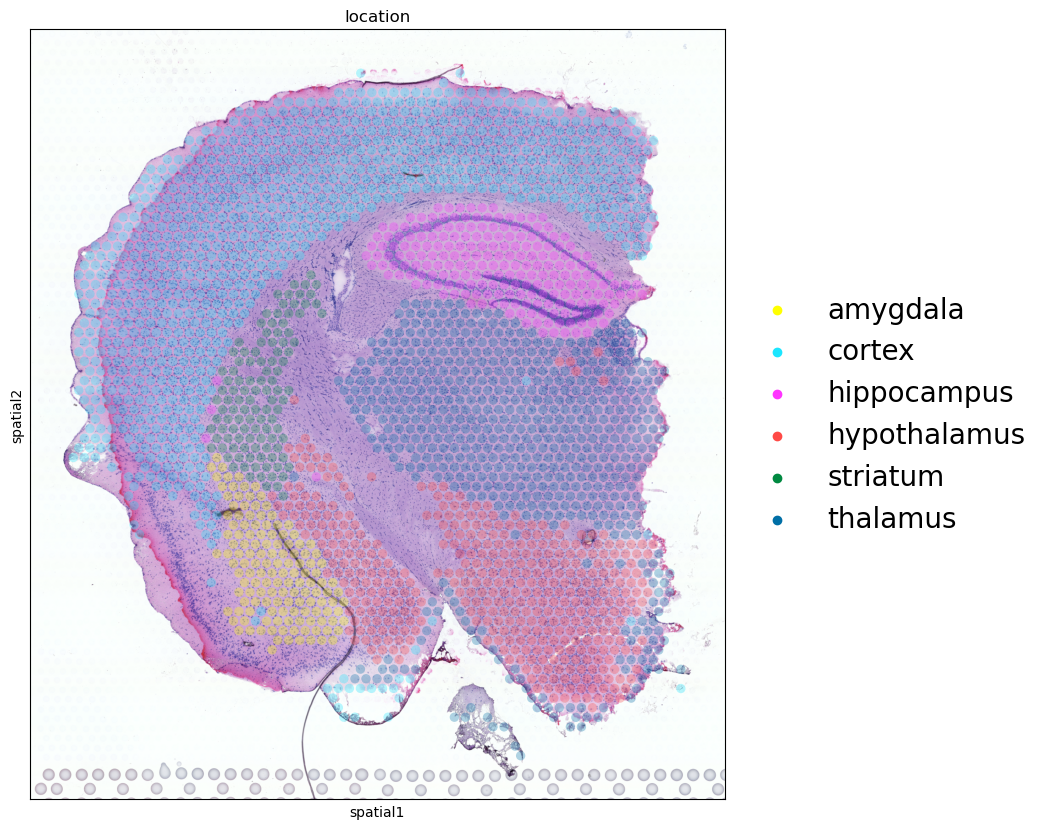

In [9]:
# identify spot locations to crop near tissue
slide = select_slide(adata_vis_matching, 'ST8059048')


mpl.rc_file_defaults()
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'figure.figsize': (10, 10), 'axes.facecolor': "black"}):
    sc.pl.spatial(slide, cmap='magma',
                  color=['location'], ncols=4, 
                  size=1.3, img_key='hires', 
                  alpha_img=1, alpha=0.3,
                  frameon=True, legend_fontsize=20,
                  vmin=0, vmax='p99.5', save='benchmark_supervised_location.pdf',
                  palette=sc.pl.palettes.default_102
                 )

In [10]:
l_names = ['thalamus', 'cortex', 'striatum', 'hypothalamus', 'amygdala', 'hippocampus']

# Define functions that compute per layer average abundance of each cell type & plot annotated scatterplot
def layer_distribution(slide, lay=None, layer_col='location', 
                       post_type='q05_spot_factors', l_names=l_names,
                       summary_fun=np.mean, proportion_per_layer=False):
    
    sel_clust_col = [post_type in i for i in slide.obs.columns]
    sel_clust_col = slide.obs.columns[sel_clust_col]
    from re import sub # create nice names
    sel_clust = [sub(post_type, '', i) for i in sel_clust_col]

    # log-transform and save with nice names
    #slides[s].obs[sel_clust] = np.log10(slides[s].obs[sel_clust_col])
    infer_lay_df = slide.obs[sel_clust_col]
    infer_lay_df.columns = sel_clust
    infer_lay_df = (infer_lay_df.T / infer_lay_df.sum(1)).T

    infer_lay = pd.DataFrame(index=sel_clust)
    for r in slide.obs[layer_col].unique():
        ind = slide.obs[layer_col].isin([r])
        # sum / mean of cell density across all spots within a region
        infer_lay[r] = summary_fun(infer_lay_df.loc[ind, :], axis=0)
    
    infer_lay = infer_lay[l_names]
    infer_lay.columns = l_names
    infer_lay = infer_lay.loc[infer_lay.sum(1) > 0, :]
    if lay is not None:
        infer_lay = infer_lay.loc[lay.index, :]
    infer_lay = infer_lay.loc[np.sort(list(infer_lay.index)), :]
    
    # convert to proportions per layer
    if proportion_per_layer is True:
        infer_lay = infer_lay / infer_lay.sum(0)
    
    return infer_lay

def plot_hist2d(x, y, xlab, ylab, log=False, scatter_kwdargs:dict={}):
    
    corr = np.corrcoef(
        x.values.flatten(), 
        y.values.flatten())[0,1]
    corr_log10 = np.corrcoef(
        np.log10(x.values.flatten() + 1), 
        np.log10(y.values.flatten() + 1))[0,1]

    if log:
        x = np.log10(x.values.flatten() + 1)
        y = np.log10(y.values.flatten() + 1)
        
        xlab = xlab + ' (log10)'
        ylab = ylab + ' (log10)'
    else:
        x = x.values.flatten()
        y = y.values.flatten()

    #plt.hist2d(x, y, bins=35, norm=matplotlib.colors.LogNorm());
    plt.scatter(x, y, **scatter_kwdargs);
    plt.xlabel(xlab);
    plt.ylabel(ylab);
    plt.xlim(0);
    plt.ylim(0);
    plt.title(r'$R^2$: ' \
              + str(np.round(corr, 3))\
              #+ r', $R^2$ log: '+ str(np.round(corr_log10, 3))
             );

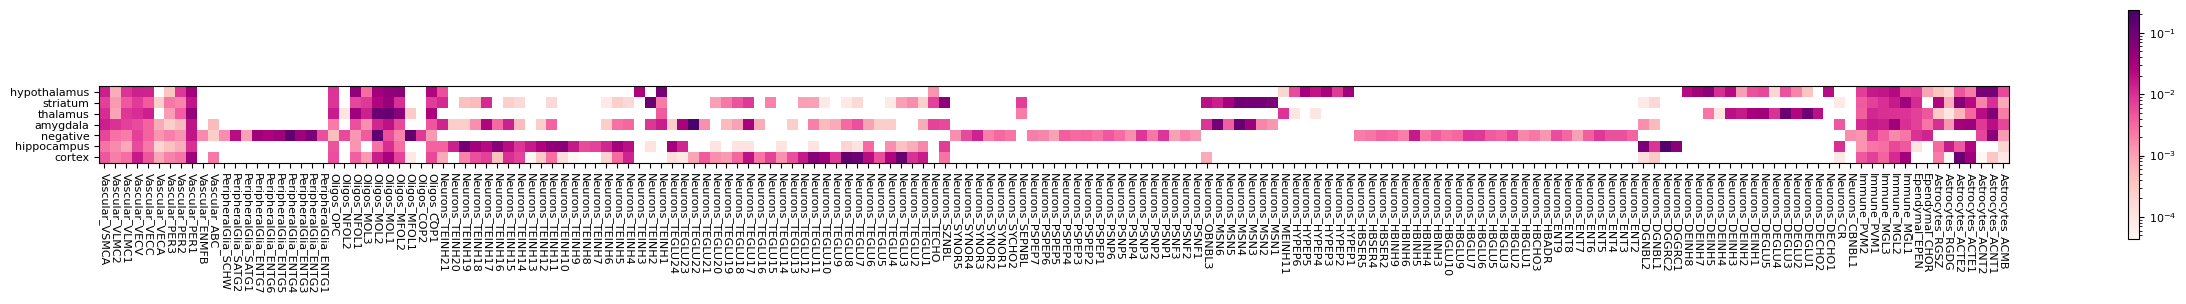

In [11]:
from cell2location.plt.plot_heatmap import clustermap

lay = count_df.copy() / count_df.sum(0)

rcParams["font.size"] = 8
rcParams["axes.facecolor"] = "white"
clustermap(lay.T, figure_size=(25, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False)

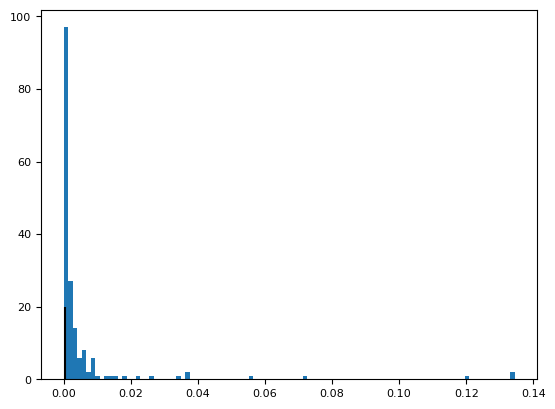

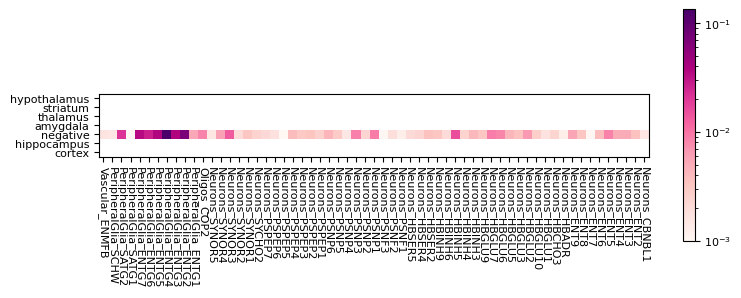

In [12]:
# selecting cell types very specific to PAR-POST-PRE compared to SSp
plt.hist(lay['negative'], bins=100);
plt.vlines(0.0005, 0, 20, color='black');
plt.show();

lay_negative = lay.loc[(lay[lay.columns[lay.columns != 'negative']].sum(1) == 0) \
                           & (lay['negative'] > 0.0005), :]
lay_negative = lay_negative.loc[np.sort(list(lay_negative.index)), :]

rcParams["font.size"] = 8
rcParams["axes.facecolor"] = "white"
clustermap(lay_negative.T, figure_size=(8, 3), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False)

In [13]:
lay_negative.shape

(61, 7)

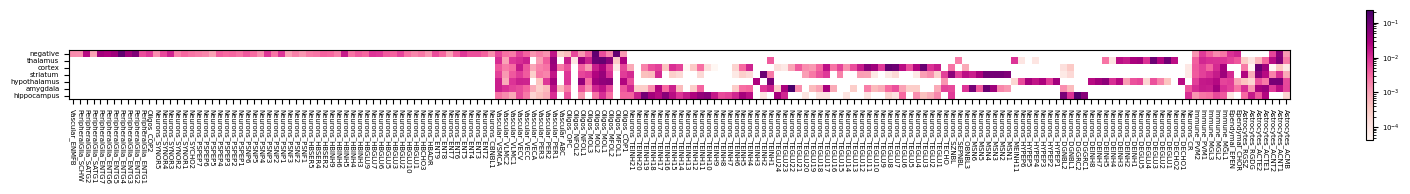

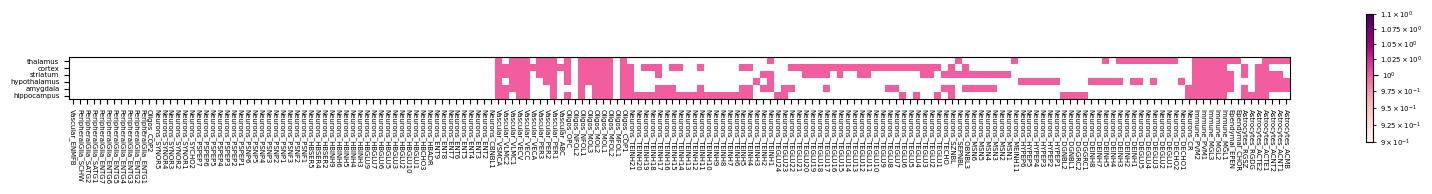

In [14]:
# reorder according to broad class
clearly_separated = [i for i in lay.index[~lay.index.isin(lay_negative.index)]] + [i for i in lay_negative.index]
lay = lay.loc[clearly_separated, ['negative'] + l_names]

gold_standard_lay = (count_df.copy() > 10).loc[lay.index, l_names]
gold_standard_lay.columns = gold_standard_lay.columns.astype(str)
lay_binary = gold_standard_lay.loc[lay.index, l_names]
gold_standard_lay = gold_standard_lay.loc[lay.index, l_names]

rcParams["font.size"] = 5
rcParams["axes.facecolor"] = "white"
clustermap(lay.T, figure_size=(16, 1.8), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False,
           #vmin=0.0003, vmax=1
          )
plt.savefig(f'{fig_path}Fig2J_suppl_Zeisel_negative_reference.pdf', bbox_inches='tight')
plt.show()

rcParams["font.size"] = 5
rcParams["axes.facecolor"] = "white"
clustermap(lay_binary.T, figure_size=(16, 1.8), 
           cmap='RdPu', log=True,
           cluster_rows=False, cluster_cols=False,
           #vmin=0.0003, vmax=1
          )
plt.savefig(f'{fig_path}Fig2J_suppl_Zeisel_negative_reference_binary.pdf', bbox_inches='tight')
plt.show()

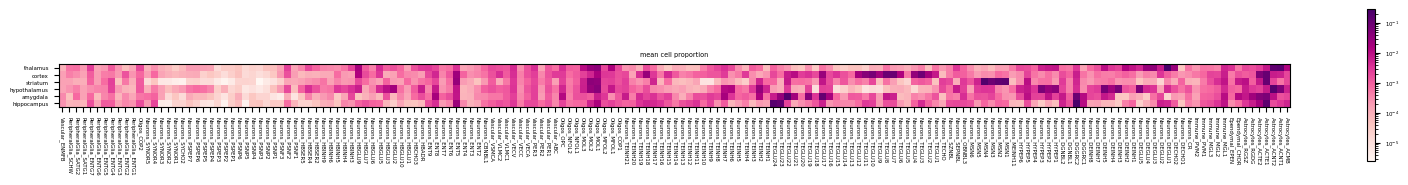

In [15]:
def summary_by(adata, sel_clust = lay_binary.index.values,
                post_type = 'q05_spot_factors',
                by_col = 'location', 
                fun=np.mean):
    sel_clust_col = [f'{post_type}{i}' for i in sel_clust]
    infer_lay_df = adata.obs[sel_clust_col]
    infer_lay_df.columns = sel_clust
    infer_lay_df = (infer_lay_df.T / infer_lay_df.sum(1)).T
    infer_lay_df[infer_lay_df.isna()] = 0

    infer_lay = pd.DataFrame(index=sel_clust)
    for r in adata.obs[by_col].unique():
        ind = adata.obs[by_col].isin([r])
        # sum / mean of cell density across all spots within a region
        infer_lay[r] = fun(infer_lay_df.loc[ind, :], axis=0)
    
    return infer_lay
    

infer_lay_nUMI = summary_by(adata_vis_matching, sel_clust = lay_binary.index.values,
                post_type = 'q05_spot_factors',
                by_col = 'location')
infer_lay_nUMI = infer_lay_nUMI.loc[lay_binary.index,:]

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(infer_lay_nUMI[lay_binary.columns].T, figure_size=(16, 1.8), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=30, vmax=10000
              )
    plt.title('mean cell proportion');
    plt.savefig(f'{fig_path}Fig2J_suppl_Zeisel_negative_cell_proportion_mapping.pdf', bbox_inches='tight')
    plt.show()

In [16]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate

with plt.style.context('seaborn'):
    seaborn_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']


def compute_precision_recall(pos_cell_count, infer_cell_proportions, mode='macro'):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                infer_cell_proportions.shape)
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = precision_recall_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = average_precision_score(pos_cell_count[:, i], predictor[:, i], average=mode)

    average_precision["averaged"] = average_precision_score(pos_cell_count, predictor,
                                                     average=mode)

    # A "micro-average": quantifying score on all classes jointly
    if mode == 'micro':
        precision_, recall_, threshold = precision_recall_curve(pos_cell_count.ravel(),
                                                                        predictor.ravel())
        #precision_[threshold < 0.1] = 0
        precision["averaged"], recall["averaged"] =  precision_, recall_

    elif mode == 'macro':
        precisions = []
        recall_grid = np.linspace(0, 1, 2000)

        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(recall[c], precision[c])
            precision_interp = f(recall_grid)
            precisions.append(precision_interp)

        precision["averaged"] = np.mean(precisions, axis=0)
        recall['averaged'] = recall_grid

        
    return precision, recall, average_precision

def compute_roc(pos_cell_count, infer_cell_proportions, mode='macro'):
    r""" Plot ROC curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    
    ### calculating ###
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, 
                                                                infer_cell_proportions.shape)
    # For each cell type
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i, c in enumerate(infer_cell_proportions.columns):
        precision[c], recall[c], _ = roc_curve(pos_cell_count[:, i],
                                                            predictor[:, i])
        average_precision[c] = roc_auc_score(pos_cell_count[:, i], predictor[:, i], average=mode)

    average_precision["averaged"] = roc_auc_score(pos_cell_count, predictor,
                                                     average=mode)

    # A "micro-average": quantifying score on all classes jointly
    if mode == 'micro':
        precision_, recall_, threshold = roc_curve(pos_cell_count.ravel(),
                                                                        predictor.ravel())
        #precision_[threshold < 0.1] = 0
        precision["averaged"], recall["averaged"] =  precision_, recall_

    elif mode == 'macro':
        precisions = []
        recall_grid = np.linspace(0, 1, 2000)

        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(recall[c], precision[c])
            precision_interp = f(recall_grid)
            precisions.append(precision_interp)

        precision["averaged"] = np.mean(precisions, axis=0)
        recall['averaged'] = recall_grid

        
    return precision, recall, average_precision

def plot_precision_recall(pos_cell_count, infer_cell_proportions,
                          title='', iso_f1_curves=False,
                          individual_cell_types=True,
                          save=None, mode='macro', curve='PR'):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    :param title: plot title
    :param iso_f1_curves: plot iso curves for F1 score?
    :param individual_cell_types: show precision-recall curves for each cell type?
    """
    
    ### calculating ###
    if curve == 'PR':
        precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions, 
                                                                        mode=mode)
        xlabel = 'Recall'
        ylabel = 'Precision'
        
    elif curve == 'ROC':
        recall, precision, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions, 
                                                                        mode=mode)
        xlabel = 'FPR'
        ylabel = 'TPR'
        
    ### plotting ###
    from itertools import cycle
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    lines = []
    labels = []
    
    if iso_f1_curves:
        f_scores = np.linspace(0.2, 0.8, num=4)
        
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

        lines.append(l)
        labels.append('iso-f1 curves')
    
    l, = plt.plot(recall["averaged"], precision["averaged"], color='navy', lw=2)
    lines.append(l)
    labels.append(f'{mode}-average {curve} ({curve} score = {round(average_precision["averaged"], 2)})')

    if individual_cell_types:
        for i, color in zip(infer_cell_proportions.columns, colors):
            l, = plt.plot(recall[i], precision[i], color='gold', lw=1)
            lines.append(l)
        labels.append(f'{curve} for individual cell types')



    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(lines, labels, loc=(0, -.37), prop=dict(size=8))
    
    if save is not None:
        plt.savefig(save)

def compare_precision_recall(pos_cell_count, infer_cell_proportions,
                             method_title, title='',
                             legend_loc=(0, -.37), font_size=12, lw=3,
                             colors=sc.pl.palettes.default_102,
                             mode='macro', curve='PR'):
    
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells), 
                                        list of inferred parameters for several methods
    :param method_title: title for each infer_cell_proportions
    :param title: plot title
    """
    # setup plot details
    from itertools import cycle
    colors = cycle(colors)
    lines = []
    labels = []
    roc = {}
    
    ### plotting ###
    for i, color in zip(range(len(infer_cell_proportions)), colors):
        
        if curve == 'PR':
            precision, recall, average_precision = compute_precision_recall(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'Recall'
            ylabel = 'Precision'
            
            l, = plt.plot(recall["averaged"], precision["averaged"], color=color, lw=lw)

        elif curve == 'ROC':
            FPR, TPR, average_precision = compute_roc(pos_cell_count, 
                                                                        infer_cell_proportions[i], 
                                                                        mode=mode)

            xlabel = 'FPR'
            ylabel = 'TPR'
            
            l, = plt.plot(FPR["averaged"], TPR["averaged"], color=color, lw=lw)
            
        
        lines.append(l)

        labels.append(method_title[i] + ' (' + curve + ' score = {0:0.2f})'
                      ''.format(average_precision["averaged"]))
        roc[method_title[i]] = average_precision["averaged"]


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend_loc is not None:
        plt.legend(lines, labels, loc=legend_loc, prop=dict(size=font_size))

    #plt.show()
    return roc


In [17]:
# call columns with q05_nUMI_factors as cell2location
sel_clust_col = [f'q05_spot_factors{i}' for i in lay_binary.index.values]

cell2location_ = adata_vis.obs[sel_clust_col]
cell2location_ = (cell2location_.T / cell2location_.sum(1)).T
adata_vis.obs[[f'cell2location_{i}' for i in lay_binary.index.values]] = cell2location_

cell2location_ = adata_vis_matching.obs[sel_clust_col]
cell2location_ = (cell2location_.T / cell2location_.sum(1)).T
adata_vis_matching.obs[[f'cell2location_{i}' for i in lay_binary.index.values]] = cell2location_

# index for per-location comparison
from re import sub
col_ind = [sub('gold_standard_','',i) for i in gold_standard.index]

## Compare methods using PR-curves

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


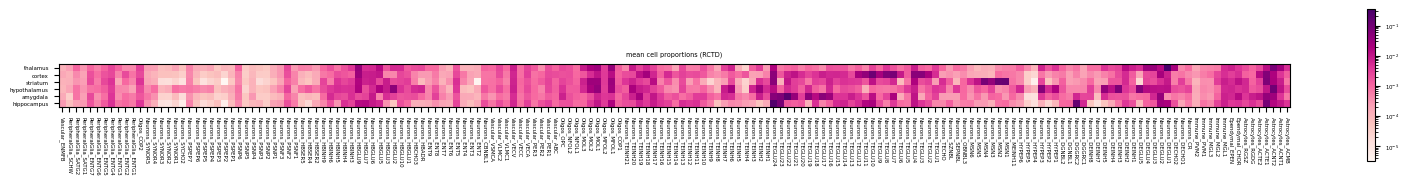

In [18]:
results_folder_st = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/zeisel_negative/'
RCTD = pd.read_csv(f'{results_folder_st}rctd/matching_regions_results_weights_121clusters_3246genes_6367genes.csv',
                   index_col='spot')
adata_vis = adata_vis[adata_vis.obs_names.isin(RCTD.index),:]

# compute cell proportions
RCTD = (RCTD.T / RCTD.sum(1)).T
RCTD = RCTD.loc[adata_vis.obs_names,:]


adata_vis_matching = adata_vis_matching[adata_vis_matching.obs_names.isin(RCTD.index),:]
adata_vis = adata_vis[adata_vis.obs_names.isin(RCTD.index),:]
adata_vis.obs[[f'RCTD_{i}' for i in RCTD.columns]] = RCTD.values
adata_vis_matching.obs[[f'RCTD_{i}' for i in RCTD.columns]] = RCTD.loc[adata_vis_matching.obs_names,:].values

RCTD_per_region = summary_by(adata_vis_matching, sel_clust = lay_binary.index.values,
                post_type = 'RCTD_',
                by_col = 'location')

results = [RCTD.loc[adata_vis_matching.obs_names, col_ind]]
results_per_region = [RCTD_per_region[lay_binary.columns]]
names = ['RCTD']

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(RCTD_per_region[lay_binary.columns].T, figure_size=(16, 1.8), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=0.001, vmax=1
              )
    plt.title('mean cell proportions (RCTD)');
    #plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping.pdf', bbox_inches='tight')
    plt.show()

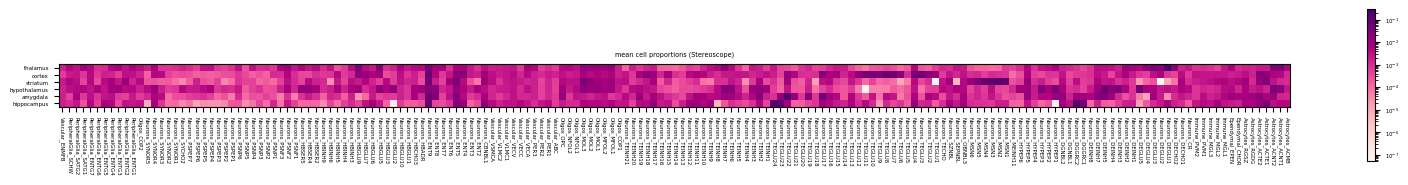

In [19]:
scvi_stereoscope = anndata.read(f'{results_folder_st}scvi_stereoscope/sp_20k.h5ad')

scvi_stereoscope = scvi_stereoscope.obsm['decomposition'].copy()
scvi_stereoscope = (scvi_stereoscope.T / scvi_stereoscope.sum(1)).T
scvi_stereoscope = scvi_stereoscope.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'scVI_Stereoscope_{i}' for i in scvi_stereoscope.columns]] = scvi_stereoscope.values
adata_vis_matching.obs[[f'scVI_Stereoscope_{i}' for i in scvi_stereoscope.columns]] = scvi_stereoscope.loc[adata_vis_matching.obs_names,:].values

scvi_stereoscope_per_region = summary_by(adata_vis_matching, sel_clust = lay_binary.index.values,
                post_type = 'scVI_Stereoscope_',
                by_col = 'location')

results = results + [scvi_stereoscope.loc[adata_vis_matching.obs_names, col_ind]]
results_per_region = results_per_region + [scvi_stereoscope_per_region[lay_binary.columns]]
names = names + ['scVI_Stereoscope']

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(scvi_stereoscope_per_region[lay_binary.columns].T, figure_size=(16, 1.8), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=0.001, vmax=1
              )
    plt.title('mean cell proportions (Stereoscope)');
    #plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping.pdf', bbox_inches='tight')
    plt.show()

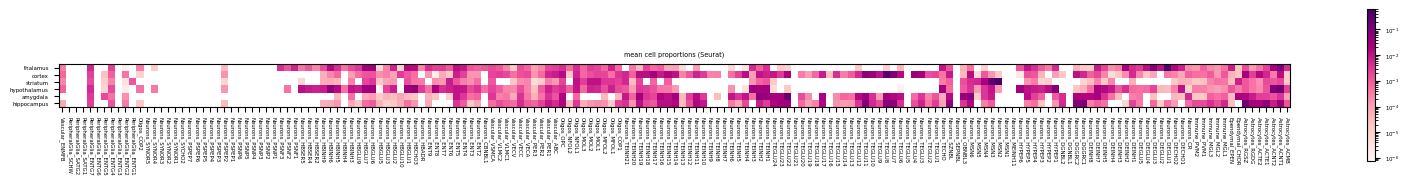

In [20]:
SeuratV3 = pd.read_csv(f'{results_folder_st}seurat_new/matching_regions_results_pca.csv',
                       index_col='spot')
SeuratV3 = SeuratV3.drop(columns=['prediction.score.max', 'Unnamed: 0', 'predicted.id'])
from re import sub
SeuratV3.columns = [sub('prediction.score.', '',i) for i in SeuratV3.columns]

seu_index = [sub(' ', '.',i) for i in infer_lay_nUMI.index]
seu_index = [sub('/', '.',i) for i in seu_index]
seu_index = [sub('-', '.',i) for i in seu_index]

SeuratV3 = SeuratV3[seu_index]
SeuratV3.columns = infer_lay_nUMI.index

# compute cell proportions
SeuratV3 = (SeuratV3.T / SeuratV3.sum(1)).T
SeuratV3 = SeuratV3.loc[adata_vis.obs_names,:]

adata_vis.obs[[f'Seurat_{i}' for i in SeuratV3.columns]] = SeuratV3.values
adata_vis_matching.obs[[f'Seurat_{i}' for i in SeuratV3.columns]] = SeuratV3.loc[adata_vis_matching.obs_names,:].values

SeuratV3_per_region = summary_by(adata_vis_matching, sel_clust = lay_binary.index.values,
                post_type = 'Seurat_',
                by_col = 'location')

results = results + [SeuratV3.loc[adata_vis_matching.obs_names, col_ind]]
results_per_region = results_per_region + [SeuratV3_per_region[lay_binary.columns]]
names = names + ['Seurat']

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white"}):
    clustermap(SeuratV3_per_region[lay_binary.columns].T, figure_size=(16, 1.8), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False,
               #vmin=0.001, vmax=1
              )
    plt.title('mean cell proportions (Seurat)');
    #plt.savefig(f'{fig_path}Fig2J_suppl_PAR_POST_PRE_mapping.pdf', bbox_inches='tight')
    plt.show()

In [21]:
pos_cell_count = adata_vis_matching.obs[[f'gold_standard_{i}' for i in col_ind]].values
cell2location = adata_vis_matching.obs[[f'cell2location_{i}' for i in col_ind]]
cell2location.columns = col_ind

results = [cell2location] + results
results_per_region =  [infer_lay_nUMI[lay_binary.columns]] + results_per_region
names = ['cell2location'] + names

In [22]:
pos_cell_count.shape, cell2location.shape

((11881, 112), (11881, 112))

In [23]:
fig_path

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/zeisel/LocationModelLinearDependentWMultiExperimentFixedGeneMeanAlpha_5experiments_175clusters_14968locations_12570genes_matching_regions_30k_mg_alpha100/plots/figures/'

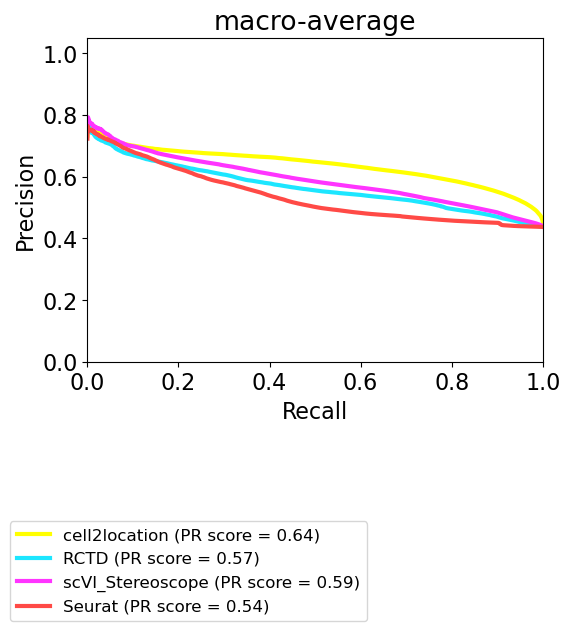

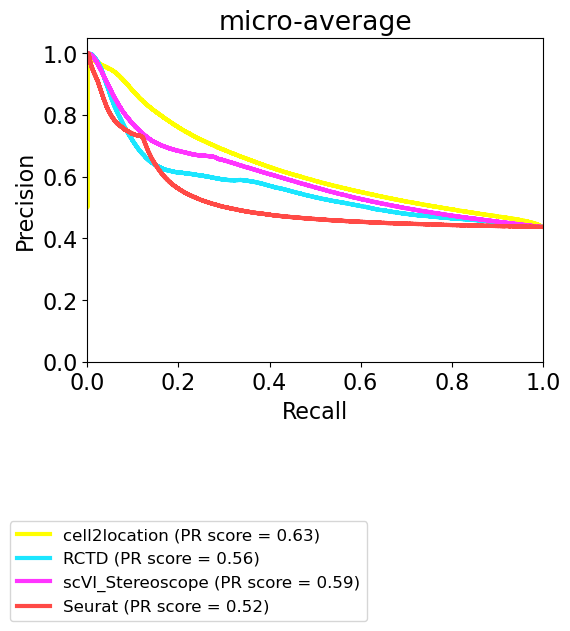

In [24]:
mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'figure.figsize': (6,7.5), 'font.size': 16}):
    
    for c in ['PR']:
        for m in ['macro', 'micro']:
            compare_precision_recall(pos_cell_count, results,
                                     method_title=names, 
                                     legend_loc=(-0.17, -0.8),
                                     mode=m, curve=c)#,
                                     #colors=['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
            plt.tight_layout()
            plt.title(f'{m}-average')
            plt.savefig(f'{fig_path}/per_location_{c}_comparison_all_{m}average.pdf')
            plt.show()

In [25]:
results_per_region[0].columns, lay_binary.columns

(Index(['thalamus', 'cortex', 'striatum', 'hypothalamus', 'amygdala',
        'hippocampus'],
       dtype='object'),
 Index(['thalamus', 'cortex', 'striatum', 'hypothalamus', 'amygdala',
        'hippocampus'],
       dtype='object'))

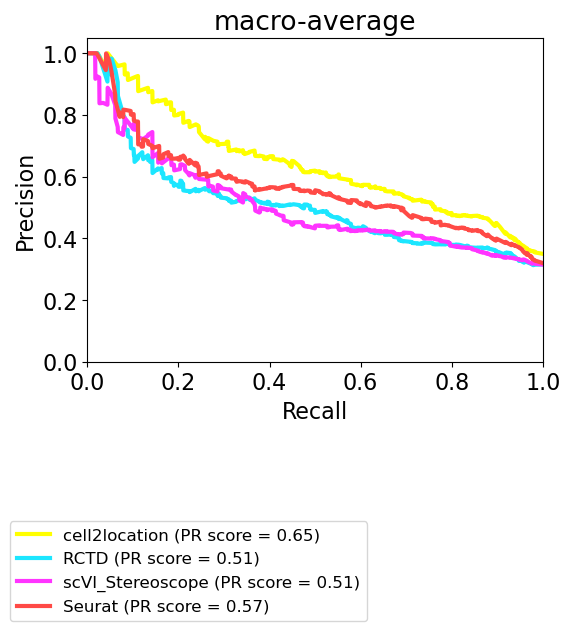

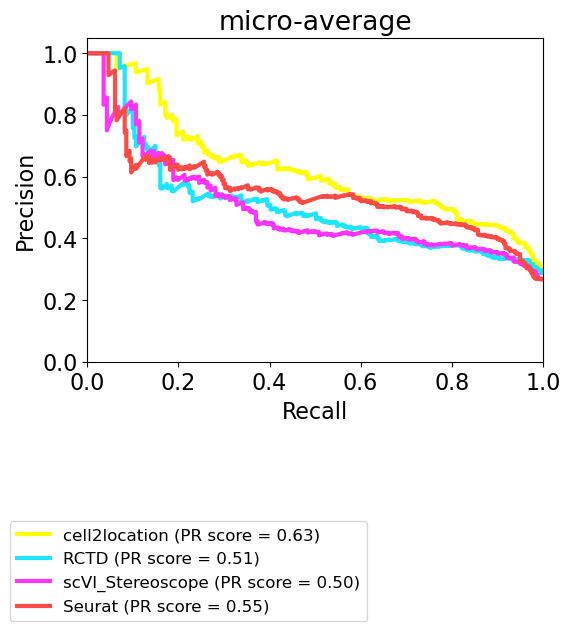

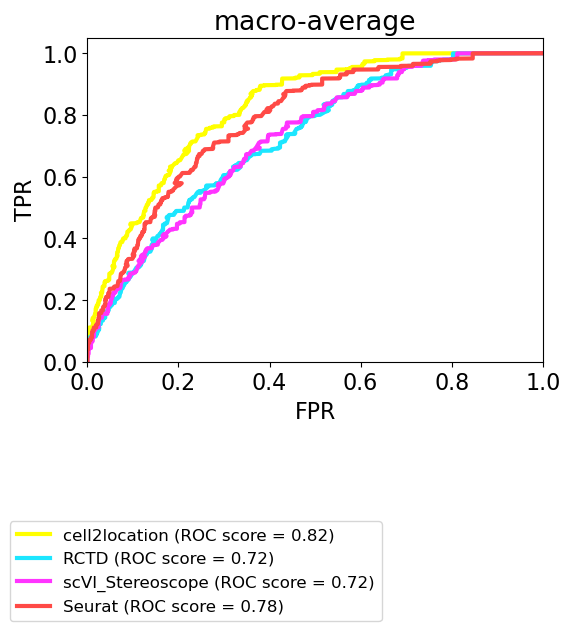

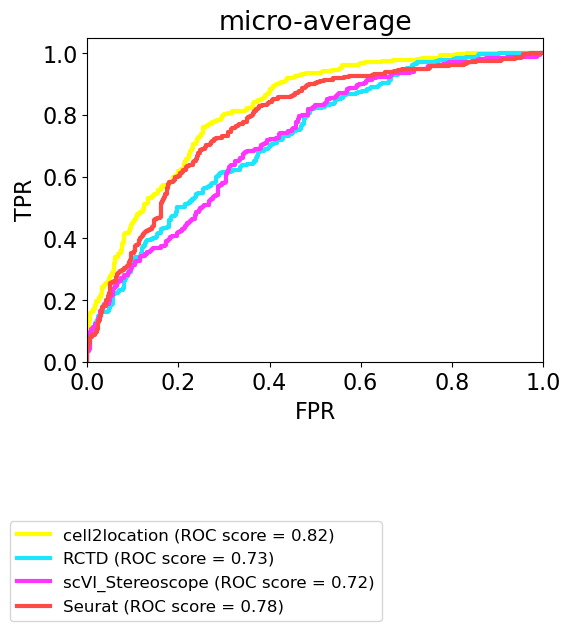

In [26]:
mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'figure.figsize': (6,7.5), 'font.size': 16}):
    
    for c in ['PR', 'ROC']:
        for m in ['macro', 'micro']:
            compare_precision_recall(lay_binary.values, results_per_region,
                                     method_title=names, 
                                     legend_loc=(-0.17, -0.8),
                                     mode=m, curve=c)#,
                                     #colors=['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
            plt.tight_layout()
            plt.title(f'{m}-average')
            plt.savefig(f'{fig_path}/per_region_{c}_comparison_all_{m}average.pdf')
            plt.show()

## Plot consistency with Zeisel cell proportions (Fig 2J) (scatter plot & R^2)

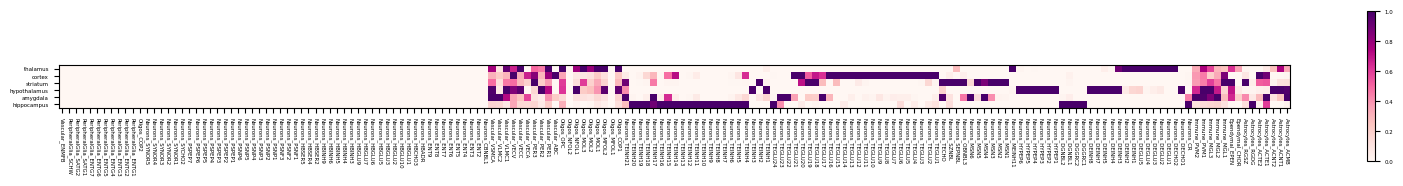

In [27]:
with mpl.rc_context({"font.size": 3.9, 'pdf.fonttype': 42, "axes.facecolor": 'white'}):
    clustermap((lay[lay_binary.columns].T / lay.max(1)), figure_size=(16, 1.8), 
               cmap='RdPu', log=False,
               cluster_rows=False, cluster_cols=False,
               #vmin=0.003, vmax=1
              )
    plt.savefig(f'{fig_path}Fig2J_Zeisel_suppl_reference_max.pdf', bbox_inches='tight')
    plt.show()

Trying to set attribute `.uns` of view, copying.


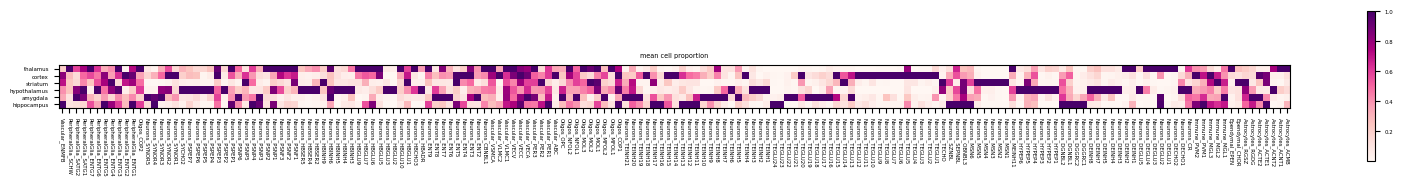

In [28]:
infer_lay_ST8059048 = summary_by(select_slide(adata_vis_matching, 'ST8059048').copy(),
                                 sel_clust = lay_binary.index.values,
                post_type = 'q05_spot_factors',
                by_col = 'location')
infer_lay_ST8059048 = infer_lay_ST8059048.loc[lay_binary.index,lay_binary.columns]

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 3.9, 'axes.facecolor': "white", 'pdf.fonttype': 42}):
    clustermap((infer_lay_ST8059048.T / infer_lay_ST8059048.max(1)), figure_size=(16, 1.8), 
               cmap='RdPu', log=False,
               cluster_rows=False, cluster_cols=False,
               #vmin=30, vmax=10000
              )
    plt.title('mean cell proportion');
    plt.savefig(f'{fig_path}Fig2J_suppl_Zeisel_negative_cell_proportion_mapping_max.pdf', bbox_inches='tight')
    plt.show()

In [29]:
fig_path

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/zeisel/LocationModelLinearDependentWMultiExperimentFixedGeneMeanAlpha_5experiments_175clusters_14968locations_12570genes_matching_regions_30k_mg_alpha100/plots/figures/'

Trying to set attribute `.uns` of view, copying.


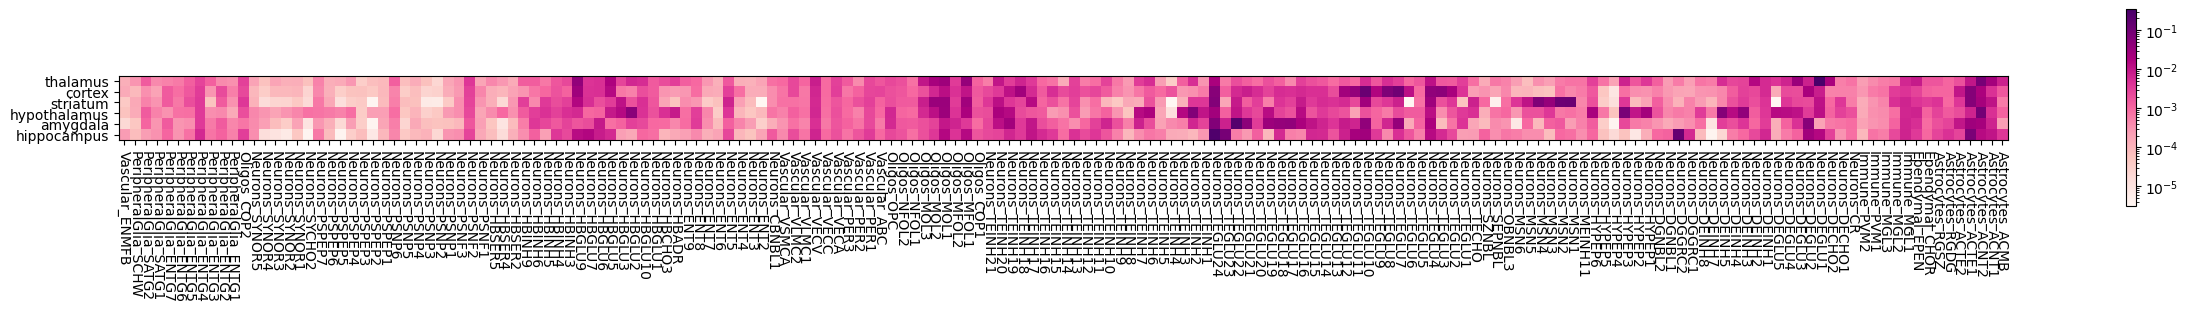

In [30]:
SPOTlight_infer_lay_ST8059048 = summary_by(select_slide(adata_vis_matching, 'ST8059048').copy(),
                                 sel_clust = lay.index,
                post_type = 'RCTD_',
                by_col = 'location')

SPOTlight_infer_lay_ST8059048 = SPOTlight_infer_lay_ST8059048 / SPOTlight_infer_lay_ST8059048.sum(0)
SPOTlight_infer_lay_ST8059048 = SPOTlight_infer_lay_ST8059048.loc[lay.index, lay_binary.columns]

with mpl.rc_context({"font.size": 10, 'pdf.fonttype': 42, "axes.facecolor": 'white'}):
    clustermap(SPOTlight_infer_lay_ST8059048.T, figure_size=(25, 3), 
               cmap='RdPu', log=True,
               cluster_rows=False, cluster_cols=False)

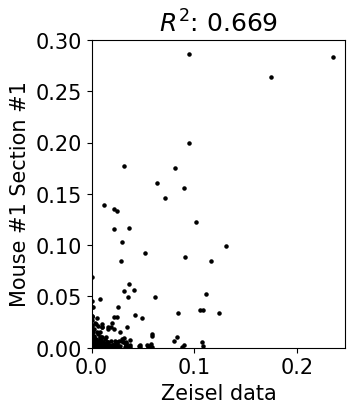

In [31]:
with mpl.rc_context({'axes.facecolor': 'white', 'font.size': 15,
                            'figure.figsize': [4, 4]}):
    
    #infer_lay_ST8059048 = infer_lay_ST8059048 / infer_lay_ST8059048.sum(0)
    infer_lay_ST8059048 = infer_lay_ST8059048.loc[lay.index,:]
    
    plot_hist2d(lay[infer_lay_ST8059048.columns], infer_lay_ST8059048, 
                'Zeisel data', 
                'Mouse #1 Section #1', 
               scatter_kwdargs={'s': 5, 'c': 'black'})
    plt.gca().set_aspect('equal', adjustable='box')
    #plt.savefig('figures/Allen_reference_vs_cell2location.pdf', bbox_inches='tight')
    
    plt.show()

In [32]:
infer_lay_ST8059048.sum(0)

thalamus        1.0
cortex          1.0
striatum        1.0
hypothalamus    1.0
amygdala        1.0
hippocampus     1.0
dtype: float64

In [33]:
def compute_corr(sample, method, lay, adata_vis):
    
    infer_lay_s = summary_by(select_slide(adata_vis, sample).copy(),
                                 sel_clust = lay.index,
                post_type = method,
                by_col = 'location')
    
    infer_lay_s = infer_lay_s / infer_lay_s.sum(0)
    infer_lay_s = infer_lay_s.loc[lay.index,lay.columns]
    
    corr = np.corrcoef(
        lay.values.flatten(), 
        infer_lay_s.values.flatten())[0,1]
    
    return corr

In [34]:
compute_corr(sample='ST8059048', method='cell2location_', 
             lay=lay[infer_lay_ST8059048.columns], adata_vis=adata_vis_matching)

Trying to set attribute `.uns` of view, copying.


0.6691548547843583

In [35]:
compute_corr(sample='ST8059052', method='RCTD_', 
             lay=lay[infer_lay_ST8059048.columns], adata_vis=adata_vis_matching)

Trying to set attribute `.uns` of view, copying.


0.5507258466159262

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


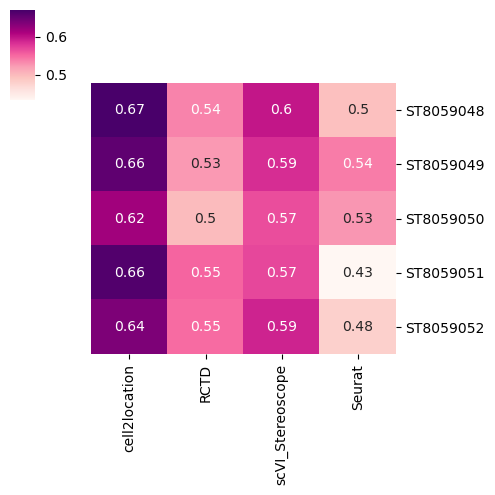

In [36]:
corrs = pd.DataFrame(index=['ST8059048', 'ST8059049', 'ST8059050', 'ST8059051', 'ST8059052'],
                     columns=names)

for s in corrs.index:
    for m in corrs.columns:
        corrs.loc[s,m] = compute_corr(sample=s, method=m+'_', 
                                      lay=lay[infer_lay_ST8059048.columns], adata_vis=adata_vis_matching)

corrs = corrs.astype('float32')

with mpl.rc_context({'axes.facecolor': 'white', 'font.size': 10}):
    import seaborn as sns
    sns.clustermap(corrs, figsize=[5, 5], cmap='RdPu', 
                   row_cluster=False, col_cluster=False, 
                   annot=corrs)

with mpl.rc_context({'axes.facecolor': 'white', 'font.size': 10}):
    import seaborn as sns
    sns.boxplot(corrs, orient="h", palette=sc.pl.palettes.default_102).set(
        xlabel='Root mean squared error'
    )
    plt.tight_layout()

In [37]:
# identify spot locations to crop near tissue
def get_crop_coord(slide):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

    crop_x = [crop_min[0]-50, crop_max[0]+50]
    crop_y = [crop_min[1]-20, crop_max[1]+0]

    return crop_x, crop_y
    

In [39]:
ct_list=list(infer_lay_nUMI.index.copy())

with mpl.rc_context({'axes.facecolor':  'black',
                            'figure.figsize': [9, 10]}):
    
    for m in names:
        for s in adata_vis.obs['sample'].unique():
        
            slide = select_slide(adata_vis, s)
            crop_x, crop_y = get_crop_coord(slide)

            if s == 'ST8059050':
                crop_x = [crop_x[0] + 50] + [crop_x[1] - 50]

            sc.pl.spatial(slide, cmap='magma',
                          color=[f'{m}_{i}' for i in ct_list], ncols=5, show=False,
                          #library_id=s,
                          size=1.3, img_key='hires', alpha_img=0, alpha=1,
                          frameon=True, legend_fontsize=50,
                          vmin=0, vmax='p99.2', save=f'all_maps_dot{s}_method{m}.pdf'
                     )

Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Trying to set attribute `.uns` of view, copying.
... storing 'old_region' as categorical
... storing 'location' as categorical
... storing 'subregion' as categorical
... storing 'cortical_layer' as categorical
... storing 'region_label' as categorical
... storing 'comments' as categorical


Modules and their versions used for this analysis

In [38]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass


sys 3.7.8 | packaged by conda-forge | (default, Nov 17 2020, 23:45:15) 
[GCC 7.5.0]
ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.19.0
IPython.core.release 7.19.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
IPython.core.crashhandler 7.19.0
pygments 2.7.2
pexpect 4.8.0
ptyprocess 0.6.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.8
wcwidth 0.2.5
jedi 0.17.2
parso 0.7.1
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 20.0.0
zmq.backend.cython 40303
zmq.backend.cython.constants 40303
zmq.sugar 20.0.0
zmq.sugar.constants 40303
zmq.sugar.version 20.0.0
jupyter_core 4.7.0
jupyter_core.version 4.7.0
tornado 6.1
_curses b'2.2'
dateutil 2.8.1
dateutil._version 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
distutils 3.7.8
scanpy 1.